 [-----------------100%-----------------] 20000 of 20000 complete in 1.9 sec

training data
test data


logp = 18.425, ||grad|| = 5,734: 100%|██████████| 18/18 [00:00<00:00, 1626.75it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 120500/120500 [00:50<00:00, 2369.75it/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112f329e8>,
      dtype=object)

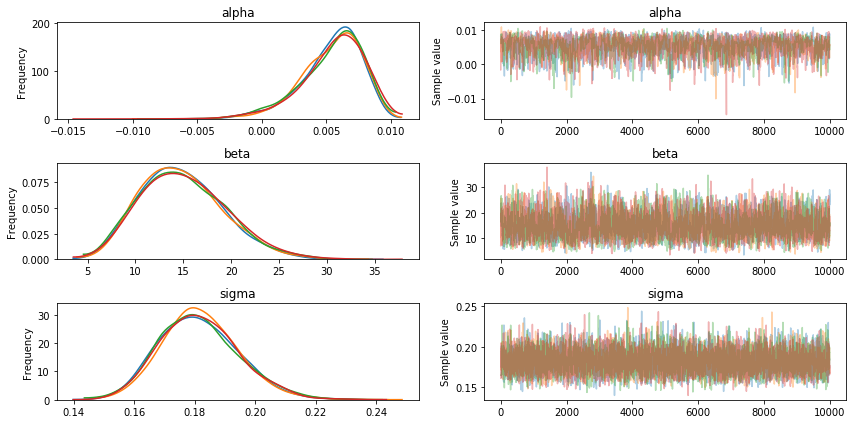

In [99]:
import pymc3 as pm
import re
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

#Import data

#domestic violence distribution - output values
domestic_violence = np.genfromtxt("DV_NSW_by_LGA.csv", skip_header=1,
                                usecols=[0, 205], missing_values="NA",
                                delimiter=",",dtype=str)


#census values - input data

#b3 - total population
#b618 M_Tot_Separated



#census values
census_values = np.genfromtxt("NSW_LGA.csv", skip_header=1,
                                usecols=[1,6, 621], missing_values="NA",
                                delimiter=",",dtype=str)


#clean census data
for i in range(len(census_values)):
    
    census_values[i][0]=census_values[i][0].split(' ')[0]
    census_values[i][1] = int(census_values[i][1])
    census_values[i][2] = int(census_values[i][2])
    
    if (int(census_values[i][1]) < 1000):
        census_values[i][1]=0
    


    
    
    
#correlate census and dva data for whole data set
training_data = []
for i in range(len(census_values)-10):
    for j in range(len(domestic_violence)):
        if (domestic_violence[j][0] == census_values[i][0]):
            
            entry = {'LGA': census_values[i][0], 'Population': census_values[i][1], 'Sep_Males':census_values[i][2],'DVA_Instances': domestic_violence[j][1]}
            entry = [census_values[i][0], census_values[i][1],census_values[i][2], domestic_violence[j][1]]
            
            training_data.append(entry)
            

test_data=[]
for i in range(10):
    for j in range(len(domestic_violence)):
        if (domestic_violence[j][0] == census_values[i+len(census_values)-10][0]):
            
            entry = {'LGA': census_values[i+len(census_values)-10][0], 'Population': census_values[i+len(census_values)-10][1], 'Sep_Males':census_values[i+len(census_values)-10][2],'DVA_Instances': domestic_violence[j][1]}
            entry = [census_values[i+len(census_values)-10][0], census_values[i+len(census_values)-10][1],census_values[i+len(census_values)-10][2], domestic_violence[j][1]]
            
            test_data.append(entry)

print('training data')
#for i in range(len(training_data)):
#    print(training_data[i][0])
    
print('test data')
#for i in range(len(test_data)):
#    print(test_data[i][0])



#we have the number of crimes, population and number of seperated males
#to form a model, assume we do not know the population and number of seperated males
#by estimating this we can find a system model


#plot a graph of population vs crime

#data = [[i[1],i[3]] for i in training_data]
sep = [float(i[2])/float(i[1]) for i in training_data]
dva = [float(i[3])/float(i[1]) for i in training_data]

sep_test = [float(i[2])/float(i[1]) for i in test_data]
dva_test = [float(i[3])/float(i[1]) for i in test_data]



#assume equation

#CRIME = (Sep_Males-Alpha)*Beta+var

#Assume normal distributions
basic_model = pm.Model()

with basic_model:
    alpha = pm.Normal('alpha',mu=.007,sd=.005)
    beta = pm.Normal('beta',mu=20,sd=10)
    sigma = pm.HalfNormal('sigma',sd=2)

    mu = (sep-alpha)*beta

    output = pm.Normal('output',mu=mu,sd=sigma,observed=dva)
    
#run simulation
with basic_model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]
    
    
    
pm.traceplot(burned_trace)






#for i in range(len(dva)):
#    if (dva[i] > .3):
#        print(training_data[i])

#historgram of domestic violence distribution
#plt.subplot(331)
#plt.hist(dva, bins=50, color="k", histtype="stepfilled", alpha=0.8)
#plt.title("Histogram of Domestic Violence")
#plt.ylim([0, None]);

#histogram of seperated males
#plt.subplot(333)
#plt.hist(sep, bins=50, color="k", histtype="stepfilled", alpha=0.8)
#plt.title("Histogram of Seperated Males")
#plt.ylim([0, None]);

#plt.subplot(313)
#plt.scatter(sep,dva)
#plt.show()




#fig = plt.figure()
#plt.scatter(sep,dva)
#fig.suptitle('Domestic Violence vs Seperated Males', fontsize=20)
#plt.xlabel('Seperated Males', fontsize=18)
#plt.ylabel('Domestic Violence', fontsize=16)



#assume relationship

#V = (SM-0.005)*20



#print(training_data[:10], "...")
#print(dva)
#dva = array(dva)
#print(dva.mean())

#assume poisson distribution
#with pm.Model() as model:
#    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
#    lambda_1 = pm.Exponential("lambda_1", alpha)



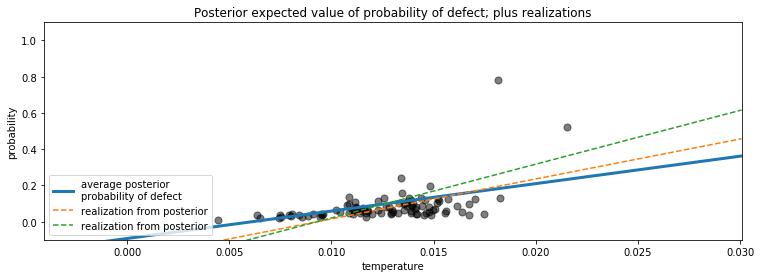

In [69]:
#dv = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
def dvfunc(x, beta, alpha=0):
    return (x-alpha)*beta


mn = 1000
mx = 0

for i in range(len(sep)):
    if sep[i] < mn:
        mn=sep[i]
    if sep[i] > mx:
        mx=sep[i]

#print(mn)
#print(mx)

alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]
sigma_samples = burned_trace["sigma"][:, None]



#output = pm.Normal('output',mu=mu,sd=sigma,observed=dva)

t = np.linspace(mn-(mx-mn)/2,mx+(mx-mn)/2,100)[:,None]
#plt.plot(t.T)

#p_t = dvfunc(t.T,beta_samples, alpha_samples)
p_t = (t.T-alpha_samples)*beta_samples
mean_prob_t = p_t.mean(axis=0)



figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[-3, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-5, :], ls="--", label="realization from posterior")
plt.scatter(sep, dva, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

#mu_samples = (t.T-alpha_samples)*beta_samples
#print(mu_samples)
#plt.subplot(211)
#plt.title(r"Posterior distributions of the variables $\alpha, \beta$")
#plt.hist(mu_samples, histtype='stepfilled', bins=35, alpha=0.85,
#         label=r"posterior of $\beta$",  normed=True)



#plt.plot(mu_samples)
#p_t = pm.Normal(t)

40000


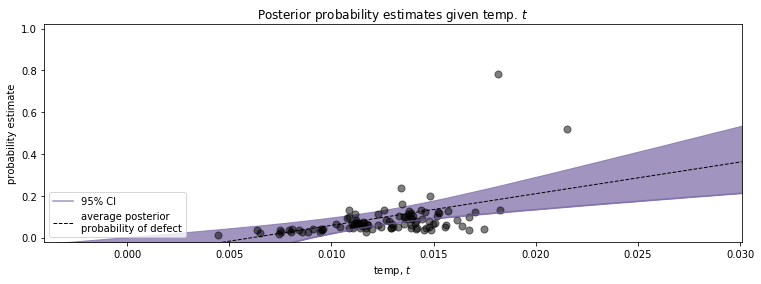

In [71]:
from scipy.stats.mstats import mquantiles
print((beta_samples).size)
# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
#print(t)
plt.fill_between(t[:, 0],
                 *qs, 
                 alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(sep, dva, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


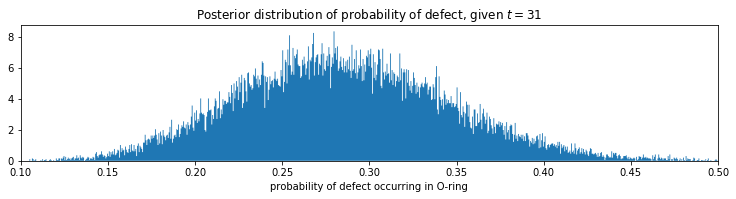

In [77]:
figsize(12.5, 2.5)

prob_31 = dvfunc(.025, beta_samples, alpha_samples)

plt.xlim(0.1,.5)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title("Posterior distribution of probability of defect, given $t = 31$")
plt.xlabel("probability of defect occurring in O-ring");

In [85]:

N = 10000
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu=.007,sd=.005)
    beta = pm.Normal('beta',mu=20,sd=10)
    sigma = pm.HalfNormal('sigma',sd=2)
    p = (sep-alpha)*beta
    observed = pm.Normal("observed", p, observed=dva)
    #simulated = pm.Normal('simulated',mu=mu,sd=sigma)
    simulated = pm.Normal("simulated", p, shape=p.tag.test_value.shape)


    #simulated = pm.Bernoulli("bernoulli_sim", p, shape=p.tag.test_value.shape)
    step = pm.Metropolis(vars=[p])
    trace = pm.sample(N, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [alpha]
>>Metropolis: [beta]
>NUTS: [simulated, sigma_log__]
100%|██████████| 10500/10500 [00:16<00:00, 643.29it/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


(40000, 99)


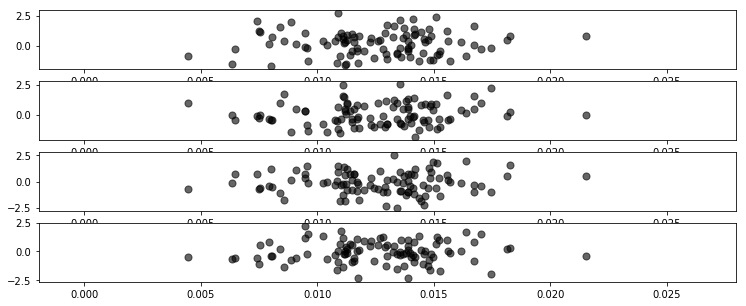

In [86]:
figsize(12.5, 5)

simulations = trace["simulated"]
print(simulations.shape)

plt.title("Simulated dataset using posterior parameters")
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i+1)
    plt.scatter(sep, simulations[1000*i, :], color="k",
                s=50, alpha=0.6)

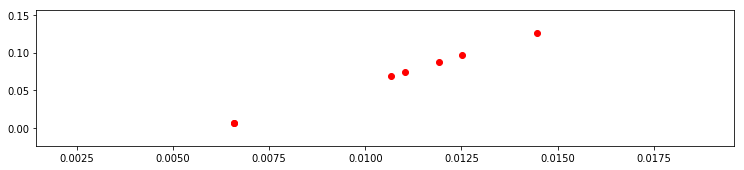

In [125]:
figsize(12.5, 2.5)

dva_estimates = []
for i in range(len(sep_test)):

    dva_estimate = dvfunc(sep_test[i], beta_samples, alpha_samples).mean()
    #print(sep_test[i],prob_31.mean())
    
    dva_estimates.append(dva_estimate)




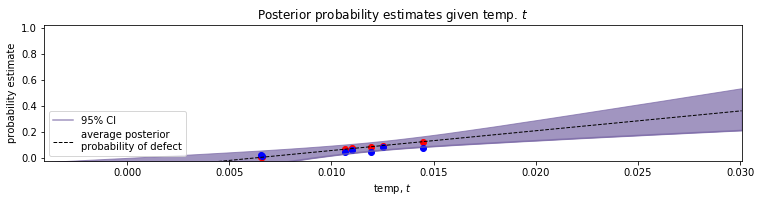

In [129]:
#plot train data

qs = mquantiles(p_t, [0.025, 0.975], axis=0)
#print(t)
plt.fill_between(t[:, 0],
                 *qs, 
                 alpha=0.7,
                 color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="average posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
#plt.scatter(sep, dva, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

#plot estimates
plt.scatter(sep_test,dva_estimates,c="r")

plt.scatter(sep_test,dva_test,c="b")